## Дальнейшие планы
#### Алгоритмы
1. Применить xgboost (не реализована)
2. Построить ансамбль и xgboost и RandomForest (не реализована)
3. Сохранение обученного алгоритма с помощью pickle

#### Подбор параметров для алгоритмов
1. Осуществить подбор пораметров с помощью GridSearchCV, Hyperopt (не реализована)

#### Анализ данных и предобработка
1. Обработка выбросов (не реализована)

#### Предметная область
1. Как OKPD связан с OKVED?
2. Как устроен OKPD?
3. Учитывать KBK (http://www.consultant.ru/document/cons_doc_LAW_190535/d06a17bdb01d31dbe5d83eb121f280d82b663641/, http://kcbux.ru/Spravochnik/kbk/sp_00_kbk-struktura.html)

In [1]:
from collections import Counter
import itertools
import time

import pandas as pd
import numpy as np

import pickle

from sklearn.model_selection import KFold, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from sklearn.feature_selection import SelectKBest, RFE, chi2
from sklearn.decomposition import PCA

from catboost import CatBoostClassifier

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 42

In [2]:
bad_cntr = pd.read_csv('../data/2-yarobl_bad_contracts.csv')
good_cntr = pd.read_csv('../data/2-yarobl_good_contracts.csv')
data = bad_cntr.append(good_cntr)
data = data.dropna()
data = shuffle(data, random_state=random_seed)
print(data.shape)
data.head(5)

(11907, 20)


,cntrID,org_cntr_num,org_1s_sev,org_1s_sup_sev,sup_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,sup_1s_sev,sup_1s_org_sev,sup_sim_price,supType,orgForm,price_higher_pmp,price_too_low,price,pmp,okpd,cntr_result
1701,1489889,2643,0.0,0.0,3,221400.0,0.0,1.0,1.00000,0,0.0,0.66667,3,0,0,1,249600.0,484210.00,0,0
3446,1410055,64,0.0,0.0,8,269412.0,0.0,1.0,1.00000,0,0.0,0.50000,3,13,0,0,379600.0,500000.00,0,1
3388,1394632,37,0.0,0.0,6,611850.0,0.0,1.0,1.00000,0,0.0,0.16667,3,13,0,0,280000.0,280000.00,0,1
673,1461932,2697,0.0,0.0,69,158718.0,0.0,1.0,1.00000,0,0.0,0.08696,3,13,0,0,144561.1,199395.00,0,0
4047,1547772,33,0.0,0.0,28,137404.0,0.0,1.0,0.60714,0,0.0,0.07143,2,8,0,0,28000.0,39421.44,0,0


## Предобработка данных

### Группировка OKPD и orgForm и One Hot Encoding

Переменная `okpd` и `orgForm` на выборке принимают более 600 и более 50 значений соответственно. При этом распределение этих
значений крайне неравномерное. 

Так, для переменной `okpd` значение 0 наблюдается у 9761 объекта. Поэтому это значение было сохранено, а все остальные сгруппированы в одно новое. Итого, количество значений переменной `okpd` было уменьшено до 2.

У переменной `orgForm` были сохранены 5 наиболее часто встречающихся значений, остальные были сгруппированы в 1. Итого, количество значений `orgForm` было уменьшено до 6.

In [3]:
# Счетчики значений
c_okpd, c_orgform = Counter(), Counter()
for org_form, okpd in zip(data.orgForm.values, data.okpd.values):
    c_okpd[str(okpd)] += 1
    c_orgform[org_form] += 1

# Наиболее популярные значения
print('Наиболее популярные сферы: {}'.format(c_okpd.most_common(5)))
print('Наиболее популярные формы организации заказчика: {}'.format(c_orgform.most_common(5)))

# Список со значениями наиболее популярных сфер контракта (ОКПД)
most_frequent_okpd_list = [int(elem[0]) for elem in c_okpd.most_common(5)]

# Список со значениями наименее популярных форм организации заказчика
most_frequent_orgform_list = [elem[0] for elem in c_orgform.most_common(5)]
rare_orgform_set = set(data.orgForm) - set(most_frequent_orgform_list)

# Группировка
data.loc[data['okpd']!=most_frequent_okpd_list[0], 'okpd'] = 111
for org_form in rare_orgform_set:
    data.loc[data['orgForm']==org_form, 'orgForm'] = 111

# One Hot Encoding
for column in ('supType', 'orgForm', 'okpd'):
    dummies = pd.get_dummies(data[column], prefix=column[:4], drop_first=True)
    data = pd.concat([data, dummies], axis=1)
    data.drop([column], inplace=True, axis=1)
    
print('Размер выбори после обработки категориальных переменных: {}'.format(data.shape))

Наиболее популярные сферы: [('0', 9761), ('869015000', 39), ('105140330', 26), ('421120000', 25), ('12410000', 22)]
Наиболее популярные формы организации заказчика: [(0, 4632), (13, 4143), (7, 1168), (8, 560), (45, 271)]
Размер выбори после обработки категориальных переменных: (11907, 26)


### Нормирование

In [4]:
column_names = data.loc[:,data.columns != 'cntr_result'].columns
scaler = StandardScaler()
columns_to_normalize = ['org_cntr_num', 'sup_cntr_num', 'sup_cntr_avg_price']

# Формирование массива признаков и значений целевой переменной
X = data.drop(['cntrID', 'cntr_result'], axis=1)
X.loc[X['pmp']==0, 'pmp'] = 1
X.loc[X['price']==0, 'price'] = 1
X['pmp'] = np.log(X['pmp'])
X['price'] = np.log(X['price'])
X.loc[:, columns_to_normalize] = scaler.fit_transform(X.loc[:, columns_to_normalize])
X = X.values

y = data.cntr_result.values

## Обучение нескольких моделей
- Logistic Regression
- Gradient Boosting
- CatBoost

In [5]:
gb_y_train_real = np.array([])
gb_y_test_real = np.array([])
gb_y_train_pred = np.array([])
gb_y_test_pred = np.array([])
gb_y_test_pred_proba = np.zeros((0, 2))

reg_y_train_real = np.array([])
reg_y_test_real = np.array([])
reg_y_train_pred = np.array([])
reg_y_test_pred = np.array([])
reg_y_test_pred_proba = np.zeros((0, 2))

cb_y_train_real = np.array([])
cb_y_test_real = np.array([])
cb_y_train_pred = np.array([])
cb_y_test_pred = np.array([])
cb_y_test_pred_proba = np.zeros((0, 2))

In [6]:
reg = LogisticRegression()
gb = GradientBoostingClassifier(random_state=random_seed)
cb = CatBoostClassifier(logging_level='Silent', random_state=random_seed)

In [7]:
start_time = time.time()

for idx, (train_index, test_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=random_seed).split(X)):
    print('Обучение {} разбиения'.format(idx + 1))
    
    X_train = X[train_index]
    X_test = X[test_index]
    
    y_train = y[train_index]
    y_test = y[test_index]
    
    reg.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    cb.fit(X_train, y_train, cat_features=[11, 12, 17])
    
    reg_y_train_real = np.concatenate((reg_y_train_real, y_train))
    reg_y_test_real = np.concatenate((reg_y_test_real, y_test))
    reg_y_train_pred = np.concatenate((reg_y_train_pred, reg.predict(X_train)))
    reg_y_test_pred = np.concatenate((reg_y_test_pred, reg.predict(X_test)))
    reg_y_test_pred_proba = np.concatenate((reg_y_test_pred_proba, reg.predict_proba(X_test))) 
    
    gb_y_train_real = np.concatenate((gb_y_train_real, y_train))
    gb_y_test_real = np.concatenate((gb_y_test_real, y_test))
    gb_y_train_pred = np.concatenate((gb_y_train_pred, gb.predict(X_train)))
    gb_y_test_pred = np.concatenate((gb_y_test_pred, gb.predict(X_test)))
    gb_y_test_pred_proba = np.concatenate((gb_y_test_pred_proba, gb.predict_proba(X_test)))
    
    cb_y_train_real = np.concatenate((cb_y_train_real, y_train))
    cb_y_test_real = np.concatenate((cb_y_test_real, y_test))
    cb_y_train_pred = np.concatenate((cb_y_train_pred, cb.predict(X_train)))
    cb_y_test_pred = np.concatenate((cb_y_test_pred, cb.predict(X_test)))
    cb_y_test_pred_proba = np.concatenate((cb_y_test_pred_proba, cb.predict_proba(X_test))) 

print("Обучение заняло %s секунд" % (time.time() - start_time))

Обучение 1 разбиения
Обучение 2 разбиения
Обучение 3 разбиения
Обучение 4 разбиения
Обучение 5 разбиения
Обучение 6 разбиения
Обучение 7 разбиения
Обучение 8 разбиения
Обучение 9 разбиения
Обучение 10 разбиения
Обучение заняло 449.10571098327637 секунд


In [8]:
def save_model(clf, clf_name):
    """Сохранение модели"""
    with open('model/{}_mdl.pkl'.format(clf_name), 'wb') as file:
        pickle.dump(clf, file)

def load_model(clf_name):
    """Загрузка модели"""
    with open('model/{}_mdl.pkl'.format(clf_name), 'rb') as file:
        return pickle.load(file)

In [10]:
save_model(gb, 'gb')
save_model(cb, 'cb')

## Функции для анализа результатов

In [11]:
def print_classifier_info(clf_name, y_train_real, y_train_pred, y_test_real, y_test_pred, y_test_pred_proba):
    """Презентация основной информации об обученной модели"""
    
    print_str = (
        '{0}\n{1}\n{2}\nТочность {3:.3f} на обучающей выборке\n'
        'Точность {4:.3f} на тестовой выборке\n'
        'Потеря перекрестной энтропии {5:.3f}\n{1}\n'
    ).format(
        clf_name.upper(),
        "=" * 55 + '\n',
        classification_report(y_test_real, y_test_pred, target_names=('Плохой', 'Хороший')),
        accuracy_score(y_train_real, y_train_pred),
        accuracy_score(y_test_real, y_test_pred),
        log_loss(y_test_real[:len(y_test_pred_proba)], y_test_pred_proba)
    )
    print(print_str)

def real_and_predicted_correlation(y_test_real, y_test_pred, y_test_pred_proba):
    """Корреляция для реальных и предсказываемых значений"""
    data = pd.DataFrame({'result': y_test_real}).join(
        pd.DataFrame({'proba_pred':y_test_pred_proba[:,0]}).join(
            pd.DataFrame({'pred': y_test_pred})
        )
    )
    return data, data.corr()

def plot_confusion_matrix(
    cm, classes, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues
):
    """Построение матрицы ошибок"""
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истинное значение')
    plt.xlabel('Предсказываемое значение')
    plt.show()
    
def plot_dependence(res, title=None):
    """
    Построение распределения контрактов по предсказываемой классификатором вероятности
    относения наблюдения к плохому классу
    """
    
    counter0 = Counter() # счетчик плохих контрактов
    counter1 = Counter() # счетчик хороших контрактов

    for index, row in res.iterrows():
        proba = round(row['proba_pred'], 2)

        if not row['result']:
            counter0[proba] += 1
        else:
            counter1[proba] += 1
    
    corr_df0 = pd.DataFrame.from_dict(counter0, orient='index').reset_index().sort_values(['index'])
    corr_df1 = pd.DataFrame.from_dict(counter1, orient='index').reset_index().sort_values(['index'])
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)

    ax.plot(corr_df0['index'], corr_df0[0])
    ax.plot(corr_df1['index'], corr_df1[0])

    plt.legend(['Плохие контракты', 'Хорошие контракты'], loc='upper left')
    plt.xlabel('Предсказываемая вероятность плохого исхода')
    plt.ylabel('Реальное количество контрактов')
    if title:
        plt.title(title)
    plt.show()

def plot_roc_curve(y_test_real, y_test_pred):
    """Построение ROC-кривой"""
    
    fpr, tpr, threshold = roc_curve(y_test_real, y_test_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--', label='Удача')
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

In [12]:
def learn_one_model(classifier, clf_name, kfold=10):
    """Функция для обучения одной модели"""
    
    start_time = time.time()

    y_train_real = np.array([])
    y_test_real = np.array([])
    y_train_pred = np.array([])
    y_test_pred = np.array([])
    y_test_pred_proba = np.zeros((0, 2))
    
    kfolds_generator = KFold(n_splits=kfold, shuffle=True, random_state=random_seed)
    
    for idx, (train_index, test_index) in enumerate(kfolds_generator.split(X)):
        print('Обучение {} разбиения'.format(idx + 1))
        
        X_train = X[train_index]
        X_test = X[test_index]
    
        y_train = y[train_index]
        y_test = y[test_index]
    
        classifier.fit(X_train, y_train)
    
        y_train_real = np.concatenate((y_train_real, y_train))
        y_test_real = np.concatenate((y_test_real, y_test))
        y_train_pred = np.concatenate((y_train_pred, classifier.predict(X_train)))
        y_test_pred = np.concatenate((y_test_pred, classifier.predict(X_test)))
        y_test_pred_proba = np.concatenate((y_test_pred_proba, classifier.predict_proba(X_test))) 
    print("Обучение заняло %s секунд\n" % (time.time() - start_time))
    print_classifier_info(clf_name, y_train_real, y_train_pred, y_test_real, y_test_pred, y_test_pred_proba)
    res, res_corr = real_and_predicted_correlation(y_test_real, y_test_pred, y_test_pred_proba)
    print(res_corr)
    plot_confusion_matrix(
        confusion_matrix(y_test_real, y_test_pred), 
        classes=classifier.classes_, 
        # normalize=True,
        title='Confusion matrix, without normalization'
    )
    plot_dependence(res)
    plot_roc_curve(y_test_real, y_test_pred)
    return classifier

## Анализ результатов

In [13]:
print_classifier_info(
    "Logistic_Regression", reg_y_train_real, reg_y_train_pred, 
    reg_y_test_real, reg_y_test_pred, reg_y_test_pred_proba
)
print_classifier_info(
    "Gradient_Boosting", gb_y_train_real, gb_y_train_pred, 
    gb_y_test_real, gb_y_test_pred, gb_y_test_pred_proba
)
print_classifier_info(
    "Cat_Boost", cb_y_train_real, cb_y_train_pred, 
    cb_y_test_real, cb_y_test_pred, cb_y_test_pred_proba
)

LOGISTIC_REGRESSION

             precision    recall  f1-score   support

     Плохой       0.95      0.83      0.89      5926
    Хороший       0.85      0.96      0.90      5981

avg / total       0.90      0.90      0.89     11907

Точность 0.896 на обучающей выборке
Точность 0.895 на тестовой выборке
Потеря перекрестной энтропии 0.285


GRADIENT_BOOSTING

             precision    recall  f1-score   support

     Плохой       0.95      0.89      0.92      5926
    Хороший       0.89      0.95      0.92      5981

avg / total       0.92      0.92      0.92     11907

Точность 0.924 на обучающей выборке
Точность 0.920 на тестовой выборке
Потеря перекрестной энтропии 0.229


CAT_BOOST

             precision    recall  f1-score   support

     Плохой       0.96      0.92      0.94      5926
    Хороший       0.92      0.97      0.94      5981

avg / total       0.94      0.94      0.94     11907

Точность 0.960 на обучающей выборке
Точность 0.943 на тестовой выборке
Потеря перекрестн

In [14]:
reg_res, reg_res_corr = real_and_predicted_correlation(reg_y_test_real, reg_y_test_pred, reg_y_test_pred_proba)
gb_res, gb_res_corr = real_and_predicted_correlation(gb_y_test_real, gb_y_test_pred, gb_y_test_pred_proba)
cb_res, cb_res_corr = real_and_predicted_correlation(cb_y_test_real, cb_y_test_pred, cb_y_test_pred_proba)

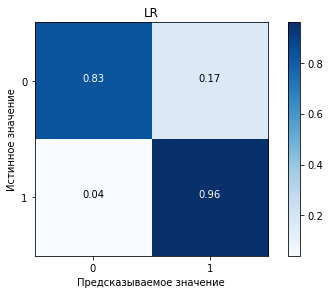

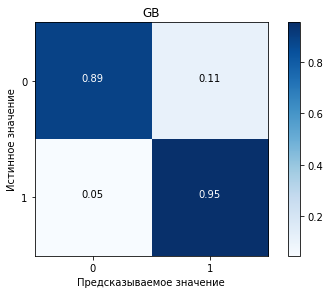

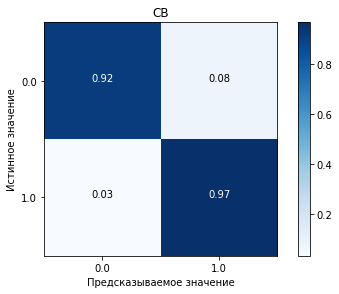

In [15]:
plot_confusion_matrix(
    confusion_matrix(reg_y_test_real, reg_y_test_pred), 
    classes=reg.classes_, 
    normalize=True,
    title='LR'
)
plot_confusion_matrix(
    confusion_matrix(gb_y_test_real, gb_y_test_pred), 
    classes=gb.classes_,
    normalize=True,
    title='GB'
)
plot_confusion_matrix(
    confusion_matrix(cb_y_test_real, cb_y_test_pred), 
    classes=cb.classes_,
    normalize=True,
    title='CB'
)

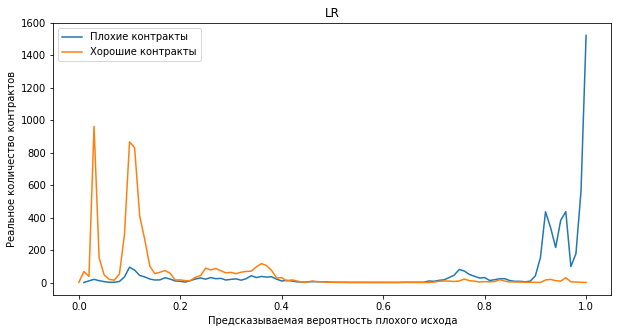

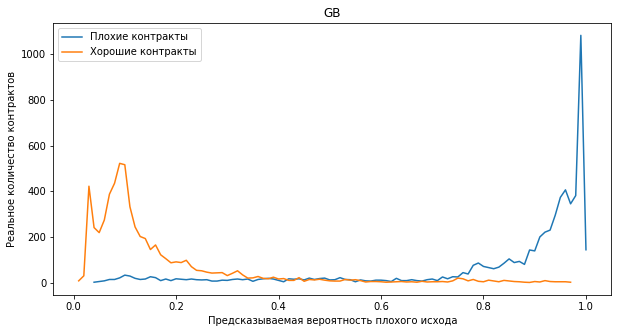

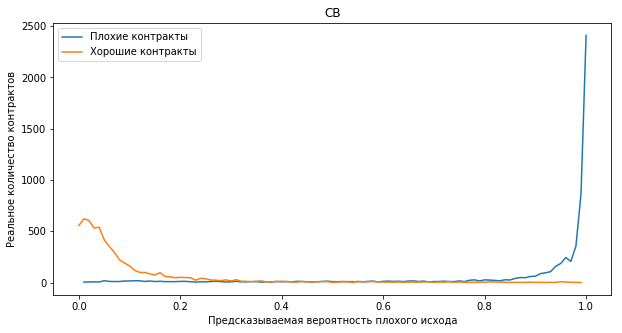

In [16]:
plot_dependence(reg_res, title='LR')
plot_dependence(gb_res, title='GB')
plot_dependence(cb_res, title='CB')

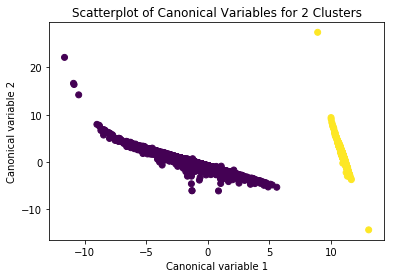

In [17]:
cls_model = KMeans(n_clusters=2).fit(X)
pca = PCA(2)
plot_columns = pca.fit_transform(X)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=cls_model.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 2 Clusters')
plt.show()

In [18]:
np.set_printoptions(precision=3, suppress=True)
print(pca.components_)
print([int(elem) for elem in pca.explained_variance_])
print([round(elem , 3) for elem in pca.explained_variance_ratio_])

[[ 0.019  0.    -0.     0.    -0.013 -0.    -0.     0.01   0.     0.     0.003
  -0.    -0.005 -0.129 -0.991  0.007 -0.001  0.001 -0.003 -0.001 -0.017
  -0.002 -0.003 -0.015]
 [-0.061  0.    -0.    -0.106  0.263 -0.     0.001  0.015  0.001  0.002
   0.042  0.    -0.032  0.947 -0.127 -0.005 -0.005  0.013 -0.009 -0.011
  -0.01   0.004  0.011 -0.007]]
[15, 1]
[0.71799999999999997, 0.091999999999999998]


In [19]:
def export_dataset():
    """Функция для экспорта датасета"""
    
    bad_cntr = pd.read_csv('../data/2-yarobl_bad_contracts.csv')
    good_cntr = pd.read_csv('../data/2-yarobl_good_contracts.csv')
    data = bad_cntr.append(good_cntr)
    data = data.dropna()
    data = shuffle(data)
    data.to_csv(path_or_buf='../data/dataset.csv', encoding='utf-8')

In [20]:
def get_classifier():
    classifiers = {
        "logistic": (LogisticRegression, ParameterGrid({
            "C": [1, 4, 10],
            "n_jobs": [-1],
            'solver': ['liblinear', 'sag']
            })),
        "GB": (GradientBoostingClassifier, ParameterGrid({
            "learning_rate": [0.3, 0.1],
            "n_estimators": [100, 240, 400],
            "max_depth": [1, 2, 3]
        })),
        "CatBoost": (CatBoostClassifier, ParameterGrid({
            "learning_rate": [0.3, 0.1],
            "n_estimators": [100, 240, 400],
            "depth": [6, 8, 10],
            "logging_level": ['Silent'],
            "random_state": [random_seed]
        }))
    }
    
    for clf_name in classifiers:
        for params in classifiers[clf_name][1]:
            yield clf_name, params, classifiers[clf_name][0](**params)
                

In [21]:
def choose_best_classifier(X, y, kfolds):
    start_time = time.time()
    
    best_clf_name = None
    best_params = None
    best_log_loss = 100  # маленький хорошо, большой плохо
    best_y_test_pred = None
    best_y_test_pred_proba = None
    best_y_test_real = None
    
    val_ind = int(X.shape[0]*0.2)
    X_valid = X[:val_ind,:]
    y_valid = y[:val_ind]
    
    X = X[val_ind:,:]
    y = y[val_ind:]
    print(X.shape, y.shape)

    for clf_name, params, clf in get_classifier():
        y_train_pred = np.array([])
        y_train_real = np.array([])

        y_test_pred = np.array([])
        y_test_pred_proba = np.zeros((0, 2))
        y_test_real = np.array([])
        
        kfold_generator = KFold(n_splits=kfolds, shuffle=True, random_state=random_seed)
        for train_index, test_index in kfold_generator.split(X):
            X_train = X[train_index]
            y_train = y[train_index]

            X_test = X[test_index]
            y_test = y[test_index]
            
            print(X_train.shape, y_train.shape)
            if clf_name == 'CatBoost':
                clf.fit(X_train, y_train, cat_features=[11, 12, 17])
            else:   
                clf.fit(X_train, y_train)
            
            y_train_pred = np.concatenate((y_train_pred, clf.predict(X_train)))
            y_train_real = np.concatenate((y_train_real, y_train))

            y_test_pred = np.concatenate((y_test_pred, clf.predict(X_test)))
            y_test_pred_proba = np.concatenate((y_test_pred_proba, clf.predict_proba(X_test)))
            y_test_real = np.concatenate((y_test_real, y_test))

        if log_loss(y_test_real, y_test_pred_proba) < best_log_loss:
            best_clf_name = clf_name
            best_params = params
            best_log_loss = log_loss(y_test_real, y_test_pred_proba)
            best_y_test_pred = y_test_pred
            best_y_test_pred_proba = y_test_pred_proba
            best_y_test_real = y_test_real

        print("{} {} train_acc: {:.3f} test_acc: {:.3f} test_log_loss {:.3f} val_acc: {:.3f} val_log_loss: {:.3f}".format(
            clf_name,
            params,
            accuracy_score(y_train_pred, y_train_real),
            accuracy_score(y_test_pred, y_test_real),
            log_loss(y_test_real, y_test_pred_proba),
            accuracy_score(clf.predict(X_valid), y_valid),
            log_loss(y_valid, clf.predict_proba(X_valid))
        ))
        
#         res, res_corr = real_and_predicted_correlation(y_test_real, y_test_pred, y_test_pred_proba)
#         plot_dependence(res, title='{} {}'.format(clf_name, params))
    print("Лучший {} {} с acc: {:.3f} и log_loss: {:.3f}".format(
        best_clf_name,
        best_params,
        accuracy_score(y_test_real, best_y_test_pred),
        log_loss(y_test_real, best_y_test_pred_proba)
    ))

    print(classification_report(
        best_y_test_real,
        best_y_test_pred,
        target_names=tuple(("Плохой", "Хороший"))
    ))
    
    print("Обучение заняло %s секунд" % (time.time() - start_time))

### Тестирование модели на новых данных

In [22]:
test_data = pd.read_csv('../data/cntr_at_federal_lvl_finished.csv')
pred_data = pd.read_csv('../data/cntr_at_federal_lvl_unfinished.csv')

In [24]:
def test_model(data, model, model_name):
    column_names = data.loc[:,data.columns != 'cntr_result'].columns
    columns_to_normalize = ['org_cntr_num', 'sup_cntr_num', 'sup_cntr_avg_price']

    # Формирование массива признаков и значений целевой переменной
    X = data.drop(['cntrID', 'cntr_result'], axis=1)
    X.loc[:, columns_to_normalize] = scaler.transform(X.loc[:, columns_to_normalize])

    X.loc[X['pmp']==0, 'pmp'] = 1
    X.loc[X['price']==0, 'price'] = 1
    X['pmp'] = np.log(X['pmp'])
    X['price'] = np.log(X['price'])
    X_test = X.values

    y_test = data.cntr_result.values
    
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)
    
    print(classification_report(y_test, y_test_pred, target_names=('Плохой', 'Хороший')))
    print('Точность {:.3f}'.format(accuracy_score(y_test, y_test_pred)))
    print('Потеря {:.3f}'.format(log_loss(y_test[:len(y_test_pred_proba)], y_test_pred_proba)))
    
    plot_confusion_matrix(
        confusion_matrix(y_test, y_test_pred), 
        classes=model.classes_,
        normalize=True,
        title=model_name
    )
    
    res, res_corr = real_and_predicted_correlation(y_test, y_test_pred, y_test_pred_proba)
    print(res_corr)
    plot_dependence(res, title=model_name)

In [25]:
# Предобработка данных для прогназирования
pred_data = pred_data.drop(pred_data[pred_data.cntr_result.notnull()].index)
pred_data = pred_data.drop(pred_data[pred_data.cntrID.isnull()].index)
pred_data = pred_data.drop(pred_data[pred_data.sup_cntr_avg_price.isnull()].index)
pred_data.drop(['cntr_result'], inplace=True, axis=1)
print(pred_data.shape)
pred_data.head(3)

(1814, 28)


,cntrID,cntrIDOOS,cntrRegNum,cntrPrintForm,cntrKBK,orgFullName,subName,supName,supINN,supKPP,...,sup_1s_sev,sup_1s_org_sev,sup_sim_price,supType,orgForm,price_higher_pmp,price_too_low,price,pmp,okpd
9,1386139,75488,171100001011000009,http://zakupki.gov.ru/pgz/printForm?type=CONTR...,NaN,Следственное управление Следственного комитета...,на право заключения государственного контракта...,Ординанс Елена Владиславовна,760407030052,0,...,0,0.0,0.5,1,0,0,0,42607.5,43550.0,0
10,1386144,76225,171100001011000010,http://zakupki.gov.ru/pgz/printForm?type=CONTR...,NaN,Следственное управление Следственного комитета...,на право заключения государственного контракта...,Голицына Мария Сергеевна,760309018018,0,...,0,0.0,0.5,1,0,0,0,42607.5,43550.0,0
12,1386180,80410,171100001011000011,http://zakupki.gov.ru/pgz/printForm?type=CONTR...,NaN,Следственное управление Следственного комитета...,на право заключения государственного контракта...,Данилова Альвина Александровна,760202795572,0,...,0,0.0,1.0,1,0,0,0,24120.0,24120.0,0


In [26]:
def build_predictions(data, model):
    X = data.iloc[:,10:]
    
    columns_to_normalize = ['org_cntr_num', 'sup_cntr_num', 'sup_cntr_avg_price']
    X.loc[:, columns_to_normalize] = scaler.transform(X.loc[:, columns_to_normalize])

    X.loc[X['pmp']==0, 'pmp'] = 1
    X.loc[X['price']==0, 'price'] = 1
    X['pmp'] = np.log(X['pmp'])
    X['price'] = np.log(X['price'])
    X = X.values
    
    return model.predict(X), model.predict_proba(X)[:,0]

# pred_data['class'], pred_data['proba'] = build_predictions(pred_data, cb)
# pred_data.drop(pred_data.columns[10:-2], inplace=True, axis=1)

In [16]:
print(pred_data.shape)
pred_data.head()
pred_data[['cntrRegNum', 'supINN', 'supKPP', 'okpd']] = pred_data[['cntrRegNum', 'supINN', 'supKPP', 'okpd']].astype(str)
pred_data.proba = pred_data.proba.round(2)
writer = pd.ExcelWriter('../predictions.xlsx')
pred_data.to_excel(writer,'Sheet1', encoding='cp1251')
writer.save()

(1814, 30)


### Анализ результатов предсказаний

In [141]:
npd = pred_data.loc[pred_data.proba >= 0.95]
npd = npd.loc[npd.cntrKBK.notnull()]
npd['cntrAdmin'] = npd['cntrKBK'].apply(lambda x: pd.Series([x[:3]]))
npd['cntrIncomeGroup'] = npd['cntrKBK'].apply(lambda x: pd.Series([x[3:4]]))
npd['cntrIncomeSubGroup'] = npd['cntrKBK'].apply(lambda x: pd.Series([x[4:6]]))

In [142]:
npd1 = npd.groupby(npd.cntrAdmin).agg({'cntrAdmin': 'count'})
npd1 = npd1.rename(columns={'cntrAdmin':'total'}).reset_index()
npd1 = npd1.rename(columns={'cntrAdmin':'adminKBKCode'})
npd1.insert(1, 'fullName', npd1['adminKBKCode'].apply(lambda elem: pd.Series(kbk_admins.get(elem, '-'))))
npd1.sort_values(by=['total'], ascending=False)

,adminKBKCode,fullName,total
9,415,Генеральная прокуратура Российской Федерации,43
2,188,Министерство внутренних дел Российской Федерации,36
10,417,Следственный комитет Российской Федерации,34
0,000,-,27
7,340,-,10
3,189,Федеральная служба безопасности Российской Фед...,7
4,226,-,5
8,393,-,5
5,310,Министерство иностранных дел Российской Федерации,3
6,320,Федеральная служба исполнения наказаний,3
